## <font color=darkblue> Optimization using second order gradient descent </font>


In this notebook, we provide an **overview of second order gradient-based optimization algorithms** which completes the first session **on first order methods and accelerated algorithms**. Supervised learning applications are usually based on the minimization of an objective function on $\mathbb{R}^d$ (kernel based SVM models, penalized regression, maximum likelihood estimation of neural networks) and accelerated gradient methods are the go-to solutions to solve these optimization problems.

The results provided in this notebook are valid with assumptions on the target functions such as convexity or strong convexity (some of them may be relaxed). Although these algorithms are widely used, keep in mind that these assumptions do not hold in practice and that  non-convexity stems from the arbitrary form of the loss functions used in machine learning.

This will motivate **additional sessions on alternative methods such as evolutionary approaches for difficult non-linear non-convex optimisation problems** in continuous and discrete domains (for instance the CMA-ES algorithm).

### <font color=darkred> Bibliography & additional ressources </font>

- [1] Convex Optimization, S. Boyd & L. Vandenberghe, 2009, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf
``Very complete book on convex optimization and gradient descent algorithms (full gradient, Newton's method, constrained problems)``
, etc.
- [2] Convex Optimization: Algorithms and
Complexity, S. Bubeck, 2015, https://arxiv.org/pdf/1405.4980.pdf

-  [3] Probabilistic machine learning: an introduction, Kevin P. Murphy, 2022, https://probml.github.io/pml-book/book1.html
``Full book online with all basics on machine learning. Not state-of-the-art but very good introduction``

- [4] Learning theory from first principles, F. Bach, 2023, https://www.di.ens.fr/~fbach/ltfp_book.pdf
``Much more advanced reference, Chapter 5 on optimization``

- [5] Algorithms for optimization, M. J. Kochenderfer and T. A. Wheeler, 2019.


### <font color=darkred>Introduction : general framework & motivations</font>

In machine learning applications, parameter inference often boils down to solving $\mathrm{argmin}_{\theta \in \mathbb{R}^d} \,\{f(\theta)=\frac 1n \sum_{i=1}^n \ell(\theta, y_i, x_i) + \lambda \mathrm{pen}(\theta)\}$, with $\lambda>0$, $\mathrm{pen}(\cdot)$ some penalization function and $(x_i,y_i)_{1\leq i\leq n}$ are ``training examples of inputs and outputs`` (in a supervised setting), and $\theta$ is an ``unknown parameter to be estimated.``

In this notebook, we do not focus on machine learning applications and **consider a generic target function $f: \mathbb{R}^d\to \mathbb{R}$**.

In [1]:
import numpy as np
import autograd
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

#### Simple cost function to test the algorithms

We may consider the Booth and Rozenbrock functions, see fo instance [5], to test the optimization procedures presented in this session:
$$
f_{\mathrm{booth}} : (x_1,x_2) \mapsto (x_1+2x_2-7)^2 + (2x_1+x_2-5)^2
$$
and
$$
f_{\mathrm{roz}} : (x_1,x_2) \mapsto (1-x_1)^2 + 100(x_2-x_1^2)^2\,.
$$


In [2]:
def rozenbrock(x):
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2

def booth(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

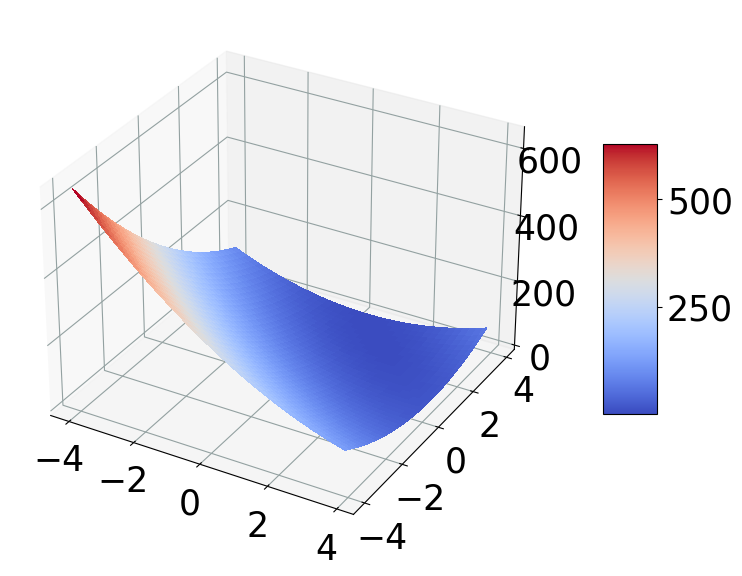

In [3]:
# Plot the surface
x = np.arange(-4, 4, 0.1)
y = np.arange(-4, 4, 0.1)
x, y = np.meshgrid(x, y)
z = booth(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### <font color=darkred> Newton's method </font>

Let $\theta_k$ be the current parameter estimate. We consider the second order Taylor expansion of the target $f$. 

More precisely, this approach proposes to locally **approximate the function $f$ around $\theta_k$ by a second-order Taylor expansion**.


From https://francisbach.com/self-concordant-analysis-newton/
![](https://drive.google.com/uc?export=view&id=1aQz3wROslBIqRB9ih_zr3LEES6LWPS0J)

In the case where $\nabla^2 f(\theta_k)$ is definite positive, the function
$$
\theta\mapsto f(\theta_k) + \theta^\top\nabla f(\theta_k) + \frac{1}{2}\theta^\top\nabla^2  f(\theta_k)\theta
$$
admits a unique minimum at 
$$
\theta_* = -(\nabla^2 f(\theta_k))^{-1}\nabla f(\theta_k)\,.
$$
This motivates the following iterative algorithm:
$$
\theta_{k+1} = \theta_k - (\nabla^2 f(\theta_k))^{-1}\nabla f(\theta_k)\,.
$$

###### **Implementation from scratch**

In [4]:
import autograd.numpy as np
import autograd

In [5]:
def NR_update(f, x):
    # Compute Jacobian and Hession matrices
    g = autograd.jacobian(f)
    h = autograd.hessian(f)
    # Evalute at x
    gx = np.squeeze(g(x))
    hx = np.squeeze(h(x))
    #####
    # A compléter
    delta = np.linalg.multi_dot([np.linalg.inv(hx), gx])
    x = x - delta
    #####
    return x

In [6]:
def NR_loop(f: callable, x0: np.ndarray, iterations: int = 50) -> tuple[np.ndarray]:
    """Compute iterative Newton updates.
    
    Parameters
    ----------
    f:
        Function to be optimized.
    x0: 
        Initial parameter estimate.
    iterations:
        Number of updates.
    
    Returns
    -------
    params:
        Estimators
    loglik:
        History of loglikelihood along iterations.
    """
    params = x0
    loglik = f(x0)
    for _ in range(iterations):
        new_params = NR_update(f, params)
        loglik = np.append(loglik,f(new_params))
        params = new_params
    return params,  loglik

- Compute the gradient and the Hessian of the Rozenbrock function. 

- Write an iteration of the Newton update for this function

$$
f_{\mathrm{roz}} : (x_1,x_2) \mapsto (1-x_1)^2 + 100(x_2-x_1^2)^2\,.
$$

The gradient is given by
$$
\nabla f_{\mathrm{roz}} (x_1,x_2) = \begin{pmatrix} -2(1-x_1) - 400x_1(x_2-x_1^2) \\ 200(x_2-x_1^2)\end{pmatrix}
$$
and the Hessian matrix by
$$
\nabla^2 f_{\mathrm{roz}} (x_1,x_2) = \begin{pmatrix} 2 - 400x_2 + 1200x^2_1 & -400x_1 \\ -400 x_1 & 200\end{pmatrix}
$$

This provides the following iterative algorithm:
$$
\theta_{k+1} = \theta_k - \begin{pmatrix} 2 - 400\theta_k(2) + 1200\theta^2_k(1) & -400\theta_k(1) \\ -400 \theta_k(1) & 200\end{pmatrix}^{-1}\begin{pmatrix} -2(1-\theta_k(1)) - 400\theta_k(1)(\theta_k(2)-\theta^2_k(1)) \\ 200(\theta_k(2)-\theta^2_k(1))\end{pmatrix}\,.
$$

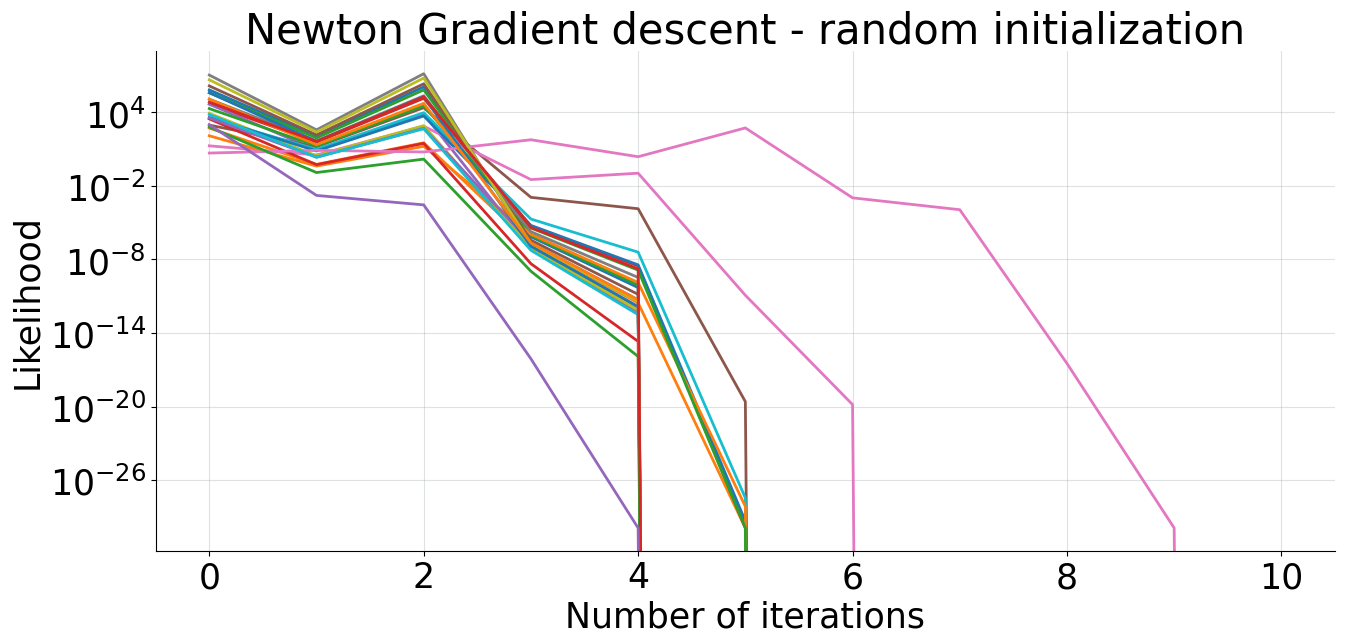

In [7]:
f = rozenbrock
iterations = 10
for exp_it in range(25):
    x0 = 5*np.random.randn(2)
    params,  lik = NR_loop(f, x0, iterations)
    plt.plot(lik, '-', lw=2)
# Configure plot
plt.yscale("log")
plt.title('Newton Gradient descent - random initialization')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.tight_layout();

###### **Convergence**

Assum that the target function $f$ is convex and twice differentiable. Assume also that:
- $\nabla f$ is $L$-Lipschitz and $\nabla^2 f$ is $M$-Lipschitz ;
- $f$ is strongly convex with parameter $m$.

Then, there exists a constant $c$, for all $k>0$,
$$
f(x_{k+k_0}) - f(x_*) \leq c \left(1/2\right)^{2^k}\,,
$$
where $k_0$ is the number of steps until $\|\nabla f(x_{k_0+1})\|$ is below a fixed threshold.

**Locally, the method is quadratically convergent**, that is, there exists $c>0$, such that if $\|x_k –x_*\|\leq c$, then $\|x_{k+1} –x_*\|/c\leq (\|x_k –x_*\|/c)^2$. Thies yields
$$
\|x_k –x_*\|⩽c(\|x_{k_0} –x_*\|/c)^{2^{k-k_0}},
$$
where $k_0$ is such that $\|x_k –x_*\|\leq c$.

Newton's method is **sensitive to initial conditions**, in particular for non-convex objective functions. 

Newton’s method is **very computationally intensive**. The computation of the inverse Hessian scales as **$O(d^3)$** which is prohibitive in high dimensional settings.

###### **Built-in optimization**

In [8]:
import torch
from autograd_minimize import minimize
x0 = 5*np.random.randn(2)
minimize(f, x0, backend="torch")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0
        x: [ 1.000e+00  1.000e+00]
      nit: 45
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 5.053e-01  1.011e+00]
            [ 1.011e+00  2.028e+00]]
     nfev: 57
     njev: 57

In [9]:
# Try switching `torch` to `tensorflow` as backend
minimize(f, x0, method='Newton-CG', precision='float64', tol=1e-8, backend="torch")

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.8932298780747465e-15
       x: [ 1.000e+00  1.000e+00]
     nit: 39
     jac: [-1.745e-08 -3.475e-08]
    nfev: 49
    njev: 49
    nhev: 60

### <font color=darkred> Quasi Newton - Broyden-Fletcher-Goldfarb-Shanno (BFGS) method</font>

Computation of the Hessian matrix is sometimes **intractable or computationally very sensitive**. Quasi-Newton approaches propose to use an update similar to the Newton Raphson algorithm with an approximation of the Hessian, i.e.
$$
\theta_{k+1} = \theta_k - \gamma_k A_k^{-1}\nabla f(\theta_k)\,.
$$

In this framework, $A_k$ aims at approximating $\nabla^2 \ell_n(\theta_k)$. This approximation satisfies in general the quasi-Newton condition:
$$
A_{k+1}(\theta_{k+1} - \theta_k) = \nabla f(\theta_{k+1}) - \nabla f(\theta_{k})\,.
$$

In the BFGS setting, the approximation of the Hessian matrix is computed recursively as follows.
- $\delta_k = \theta_{k+1}-\theta_k$.
- $d_k = \nabla\ell_n(\theta_{k+1}) -\nabla\ell_n(\theta_k)$. 
- $A_{k+1} = A_k + \left(d_k^\top \delta_k\right)^{-1}d_kd_k^\top - \left(\delta_k^\top A_k\delta_k\right)^{-1}A_k\delta_k(A_k\delta_k)^\top$. 

Using **Woodbury formula**, we can directly compute $A_{k+1}^{-1}$ as follows.
\begin{align*}
\alpha_k &= (d_k^\top \delta_k)^{-1}\,,\\
A_{k+1}^{-1} &= \left(I - \alpha_k \delta_k d_k^\top\right)A_{k}^{-1}\left(I - \alpha_k d_k\delta_k^\top\right) + \alpha_k \delta_k \delta_k^\top
\end{align*}

###### **Line search**

Each iteration of a line search method decides the step-size $\gamma_k$ i.e. the **amplitude of the update**. The iteration is given by
$$
\theta_{k+1} = \theta_{k} + \gamma_k p_k\,,
$$
where $p_k = - A_k^{-1}\nabla f(\theta_k)$.

Most line search algorithms require $p_k$ to be a descent direction:
$$
p_k^\top \nabla f(\theta_k) <0\,.
$$

Choosing $A_k$ as the identity matrix yields first order optimization algorithms, while in Newton’s method, $A_k$ is the exact Hessian matrix.

The ideal choice of the step-size is the global minimizer of $\alpha \mapsto f(\theta_k + \alpha p_k)$ which is computationally intractable.

From [6]
![](https://drive.google.com/uc?export=view&id=1yL5A7FPZ274tLbNOuuITY1JufwPmUI-C)

Computing the step length $\gamma_k$ amounts to solving a tradeoff between decreasing the value of $f$ and not spending too much time at each iteration.

A popular line search condition targets to choose $\gamma_k$ such that:
$$
f(\theta_k + \gamma_kp_k ) \leq \ell_n (\theta_k ) + c_1 \gamma_k \nabla f(\theta_k)^\top p_k\,,
$$
for $p_k = -A_k^{-1}\nabla f(\theta_k)$ some constant $0<c_1<1$.

From [6]
![](https://drive.google.com/uc?export=view&id=1rTI4Hxo5EOkBnApX5pEDrj-TxPxpm3v0)

A second requirement to avoid too short steps requires that
$$
\nabla f(\theta_k + \gamma_k p_k )^\top
p_k \geq c_2 \nabla f(\theta_k)^\top p_k
$$
where $c_1<c_2<1$.

From [6]
![](https://drive.google.com/uc?export=view&id=1XJa8Wc34oaV-iyxgAxO4hh2U13_aUqCK)

###### **Implementation from scratch**

In [10]:
def line_search(
    func: callable,
    x: np.ndarray,
    p: np.ndarray,
    nabla: np.ndarray
) -> float:
    """
    Parameters
    ----------
    f:
        Function to be optimized.
    x:
        Current parameter estimate.
    p:
        Current value of `p`.
    nabla:
        Current value of the gradient. 
    
    Returns
    -------
    The step-size gamma.
    """
    g = autograd.jacobian(func)
    # Initialization
    gamma = 1
    c1 = 1e-4 
    c2 = 0.9 
    
    fx = func(x)
    x_new = x + gamma * p 
    nabla_new = g(x_new)
    ###
    # A compléter
    ####
    while func(x_new) >= fx + (c1*gamma*nabla.T@p) or nabla_new.T@p <= c2*nabla.T@p : 
        gamma *= 0.5
        x_new = x + gamma * p 
        nabla_new = g(x_new)
    return gamma

In [11]:
def BFGS_loop(func: callable, x0: np.ndarray, iterations: int) -> np.ndarray:
    """
    Parameters
    ----------
    func:
        Function to be optimised. 
    x0:
        Starting point.
    iterations: 
        Number of iterations.

    Returns
    ------- 
    Parameter estimate. 
    """
    d = len(x0)
    g = autograd.jacobian(func)
    nabla = g(x0)
    H = np.eye(d) 
    params = x0[:]
    for _ in range(iterations):
        ###
        # A compléter
        # search direction p and step size with line search
        ###
        p = -H@nabla 
        a = line_search(f,params,p,nabla) 
        s = a * p 
        
        params_new = params + a * p 
        nabla_new = g(params_new)
        
        y = nabla_new - nabla 
        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y,(d,1))
        s = np.reshape(s,(d,1))

        r = 1/(y.T@s)
 
        li = (np.eye(d)-(r*((s@(y.T)))))
        ri = (np.eye(d)-(r*((y@(s.T)))))
        hess_inter = li@H@ri
        H = hess_inter + (r*((s@(s.T)))) 
        
        nabla = nabla_new[:] 
        params = params_new[:]

    return params

In [12]:
params = BFGS_loop(f,x0,5)

###### **Built-in optimization**

In [13]:
minimize(f, x0, method='BFGS', precision='float64', tol=1e-8, backend="torch")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.808069279078484e-18
        x: [ 1.000e+00  1.000e+00]
      nit: 44
      jac: [ 9.673e-09 -3.503e-09]
 hess_inv: [[ 5.005e-01  1.001e+00]
            [ 1.001e+00  2.007e+00]]
     nfev: 57
     njev: 57

###### **Comparison with first order methods**

In this section we compare second order approaches with first order optimization methods such as the **full gradient descent** and **Nesterov accelerated algorithm** (see first session).

In [14]:
def gradient_descent(f, nabla, w0, iterations, step_size):
    loss_history = []
    w = w0.copy()
    for k in range(iterations):
        w = w - step_size * nabla(w)
        loss_history.append(f(w))
    return w, loss_history

In [15]:
def nesterov_gd(f, nabla, w, iterations, step_size, beta):
    loss_history = []
    v = w.copy()
    for k in range(iterations):
        v_new = w - step_size * nabla(w)
        w = v + beta * (v_new - v)
        v = v_new
        loss_history.append(f(w))
    return w, loss_history

Compare Newton or Quasi Newton approach with these first order approaches

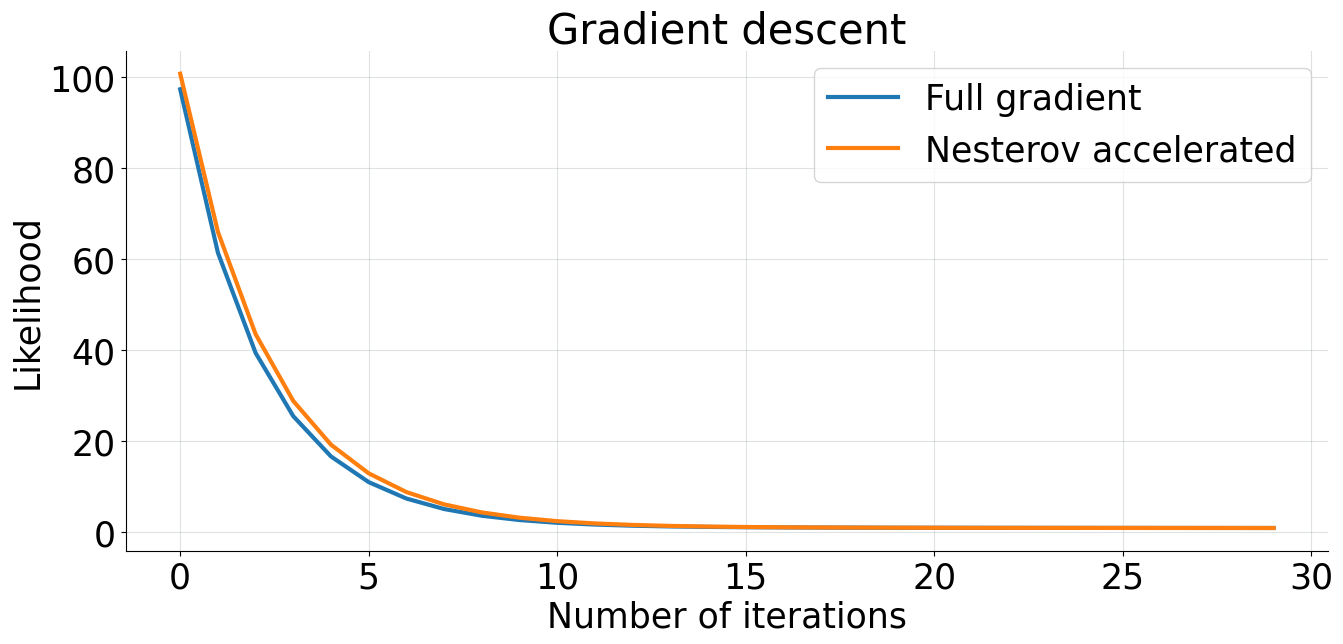

In [16]:
f = rozenbrock
nabla = autograd.jacobian(f)

beta = 0.95
step_size = 1e-3
iterations = 30
w0 = np.random.randn(2)

# Compute Nesterov gradient descent
w, loss_history = nesterov_gd(f, nabla, w0, iterations, step_size, beta)

# Compute full gradient descent
w_full, loss_history_full = gradient_descent(f, nabla, w0, iterations, step_size)

plt.plot(loss_history_full, '-', lw=3, label="Full gradient")
plt.plot(loss_history, lw=3, label="Nesterov accelerated")
# Configure plot
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.tight_layout()
plt.legend();

### <font color=darkred> Application to Design</font>

###### **Loss function**

###### **Optimization**

### <font color=darkred>Appendix: introduction to Jax</font>

[Jax](https://github.com/google/jax) allows to use python and numpy functions with automatic gradient computation, and fast linear algebra through just in time (jit) compilation.

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, grad

**Basic algebra**

In [ ]:
W = jnp.zeros((4,4))
x = jnp.ones((2))
jnp.dot(x, W)

**Gradients**

`grad` outputs the gradient of any function $f$ given in input. 
. 

In [ ]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(1.0))

https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html